In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
from scipy.fft import ifft2, fft2, fftshift, ifftshift, fftfreq
from scipy.signal import zoom_fft, convolve2d
from PIL import Image

In [2]:
def complex_gaussians(N: int) -> np.ndarray:
    """
    Returns an N*N array of random complex gaussians with unit variance.
    """
    return (np.random.standard_normal((N, N)) + 1j * np.random.standard_normal((N, N))) / np.sqrt(2)


def frequency_grid(N: int, D: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Return a 2D grid of spatial frequencies [cycles/m] up to the Nyquist frequency
    of the telescope aperture (in each direction), with zero at the center
    """
    fx, fy = np.meshgrid(fftshift(fftfreq(N, D/N)),
                         fftshift(fftfreq(N, D/N)))
    return fx, fy


def position_grid(N: int, D: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Return a 2D grid of position values [cycles/m] for the telescope aperture
    """
    x, y = np.meshgrid(np.linspace(-D/2, D/2, N),
                       np.linspace(-D/2, D/2, N))
    return x, y


def kolmogorov_spectrum(fx: np.ndarray, fy: np.ndarray, r0: float) -> np.ndarray:
    """
    Returns the Kolmogorov power spectral densities at the given spatial frequencies.
    Parameters:
        fx, fy: Spatial frequency arrays [cycles/m]
        r0: The Fried parameter [m]
    Reference: Krishnappa and Feller eq. (2)
    """
    f = np.maximum(np.hypot(fx, fy), 1e-9)
    Phi = 0.023 * np.pow(r0, -5/3) * np.pow(f, -11/3)

    # Zero out the DC component (which is infinity from this formula)
    N = Phi.shape[0]
    Phi[N // 2, N // 2] = 0.0
    return Phi


def phase_screen_spectrum(N: int, D: float, r0: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Return the spatial fourier transform of a phase spectrum.

    Parameters:
        N: Number of pixels in each dimension
        D: The diameter of the telescope [m]
        r0: The Fried parameter [m]

    Returns:
        phi_hat: Fourier transform of the phase screen [rad]

    Reference: Tubbs eq. (1)
    """
    # Compute power spectrum and multiply by an array of independent unit-variance Gaussians
    fx, fy = frequency_grid(N, D)
    K = np.sqrt(kolmogorov_spectrum(fx, fy, r0))
    R = complex_gaussians(N)
    phi_hat = R * K

    return phi_hat


def spectrum_to_phase_screen(phi_hat: np.ndarray) -> np.ndarray:
    """
    Converts the frequency spectrum (phi_hat) of a phase screen into an actual
    phase screen using an inverse FFT.
    """
    return np.real(fftshift(fft2(ifftshift(phi_hat))))


def phase_screen(N: int, D: float, r0: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Conveinence function to directly generate a phase screen 
    """
    return spectrum_to_phase_screen(phase_screen_spectrum(N, D, r0))


def shift_phase_screen(phi_hat: np.ndarray, fx: np.ndarray, fy: np.ndarray, dx: np.ndarray) -> np.ndarray:
    """
    Returns an N*N array of complex coefficients which when multiplying
    the frequency spectrum, shift the pattern in space by dx

    Parameters:
        phi_hat: Phase scren frequency spectrum
        fx, fy: Arrays of spatial frequencies [cycles/m]
        dx: 2D shift to apply to the pattern [m]

    Reference: Glindeman et al. eq (9)
    """
    return phi_hat * np.exp(2 * np.pi * 1j * (fx * dx[0] + fy * dx[1]))


def phase_screen_over_time(N: int, D: float, r0: float, v: np.ndarray,
                           M: float, t_max: float, dt: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns a 3D array representing a phase screen evolving over time with phase boiling.

    Parameters:
        N: Number of pixels in each dimension
        D: The diameter of the telescope [m]
        r0: The Fried parameter [m]
        v: Wind drift fvelocoty [m/s]
        M: Temporal correlation coefficient [m]
        t_max: Maximum time to simulate until [m/s]
        dt: Time step [s]

    Returns:
        phi: 3D Array of phase screens over time (shape is [t_max/dt, N, N]) [rad]
        t: Array of times at which the phase screens are sampled [s]

    Reference: Glindeman et al. eq (8)
    """
    t_values = np.arange(0, t_max + dt, dt)
    fx, fy = frequency_grid(N, D)
    phi = np.zeros((t_values.size, N, N))

    # Compute initial phase screen
    phi_hat = phase_screen_spectrum(N, D, r0)
    phi[0] = spectrum_to_phase_screen(phi_hat)

    # At each subsequent time step, combine shifted and new phase screen using a
    # frequency-dependent weight (alpha)
    alpha = M * np.hypot(fx, fy)

    for i, t in enumerate(t_values[1:]):
        dx = v * dt

        phi_hat_shifted = shift_phase_screen(phi_hat, fx, fy, dx)
        phi_hat_new = phase_screen_spectrum(N, D, r0)
        phi_hat = (phi_hat_shifted + alpha * phi_hat_new) / \
            np.hypot(np.ones((N, N)), alpha)

        phi[i+1] = spectrum_to_phase_screen(phi_hat)

    return phi, t_values

In [3]:
def pupil_function(N: int, D: float) -> np.ndarray:
    """
    Return the pupil transmission function for the lens (1 for points inside the aperture,
    0 for points outside).
    """
    x, y = position_grid(N, D)
    return np.hypot(x, y) < D/2


def aperture_over_time(N: int, D: float, r0: float, v: np.ndarray,
                       M: float, t_max: float, dt: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns a 3D array representing the complex wave amplitude at the aperture over time
    (assuming coherent input light with unit intensity)
    
    Returns:
        U: 3D Array of aperture amplitudes (shape is [t_max/dt, N, N]) [rad]
        t: Array of sampling times [s]

    Reference: Wikipedia, atmospheric seeing.
    """
    t = np.arange(0, t_max + dt, dt)
    phi, _ = phase_screen_over_time(N, D, r0, v, M, t_max, dt)
    p = pupil_function(N, D)

    U = np.zeros((t.size, N, N), dtype=np.complex128)

    for i, phi_t in enumerate(phi):
        U[i] = p * np.exp(1j * phi_t)

    return U, t

In [4]:
def aperture_to_image(U: np.ndarray, D: float, N: int, f_max: float, N_sensor: int) -> np.ndarray:
    """
    Computes the complex amplitude in the image plane given the input intensity
    and target geometry, under the Fraunhofer approximation.

    Parameters:
        U: Aperture complex amplitude
        D: Aperture diameter [m]
        N: Number of pixels in the aperture
        f_max: Frequency corresponding to the egde of the sensor [cycles/m] 
        N_sensor: Number of pixels across the sensor

    Returns:
        U_hat: Complex amplitude in the sensor plane
    """
    # We use zoom fft to focus on a small region of frequency space
    # It can only be applied to one axis at a time, so we must call the function twice
    fs = N / D
    U_hat_x = zoom_fft(U, [-f_max, f_max], m=N_sensor, fs=fs, axis=1)
    U_hat = zoom_fft(U_hat_x, [-f_max, f_max], m=N_sensor, fs=fs, axis=0)

    return U_hat


def crop_center(x: np.ndarray, N: int) -> np.ndarray:
    """
    Helper function to crop only the central N*N portion of a 2D array. Assumes both N and X
    have even dimension (to avoid off-by-one edge cases)
    """
    assert N % 2 == 0
    assert x.shape[0] == x.shape[1]
    assert x.shape[0] % 2 == 0

    X = x.shape[0]
    return x[X//2 - N//2:X//2 + N//2, X//2 - N//2:X//2 + N//2]


def point_spread_function_over_time(f: float, ds: float, wl: float, N_sensor: int,
                                    N: int, D: float, r0: float, v: np.ndarray,
                                    M: float, t_max: float, dt: float) -> np.ndarray:
    """
    Returns the point spread function (image of a normally incident plane wave) over time. Crops
    each function to a central portion of the sensor to speed up downstream convolution and remove
    weird aliasing at the edges.

    Parameters:
        f: Telescope focal length [m]
        ds: Sensor size [m]
        wl: Telescope imaging wavelength [m]
        N_sensor: Number of pixels on the sensor
        (see phase_screen_over_time for other parameters)

    Returns:
        intensity_PSFs: Intensity PSF at each time step - shape is [t_max/dt, N_sensor/9, N_sensor/8]
        t: Array of sampling times [s]
    """
    # Compute some derived telescope paremetrs
    # Maximum frequency in Fourier plane [cycles/m]
    f_max = ds / (f * wl)
    U, t = aperture_over_time(N, D, r0, v, M, t_max, dt)

    # Compute point spread function (PSF) for each aperture frame.
    amplitude_PSFs = np.array([
        crop_center(aperture_to_image(U_t, D, N, f_max, N_sensor), N_sensor // 8) for U_t in U
    ])
    intensity_PSFs = np.square(np.abs(amplitude_PSFs))

    # Normalize each intensity PSF to sum to one (this should be guaranteed up to a constant factor
    # in the continuous case but this gets messed up by the zoom FFTs and cropping)
    intensity_PSF_sums = np.sum(intensity_PSFs, axis=(1, 2))
    intensity_PSFs = (intensity_PSFs.T / intensity_PSF_sums).T

    return intensity_PSFs, t


def long_exposure_psf(f: float, ds: float, wl: float, N_sensor: int,
                      N: int, D: float, r0: float, v: np.ndarray,
                      M: float, T: float, N_timesteps: float) -> np.ndarray:
    """
    Returns the point spread function (image of a normally incident plane wave) averaged over
    the specified time interval.

    Parameters:
        T: Exposure time [s]
        N_timesteps: Number of timesteps
        (see point_spread_function_over_time for other parameters)

    Returns:
        intensity_PSF: Time averaged PSF - shape is [N_sensor/8, N_sensor/8]
    """
    intensity_PSFs, t = point_spread_function_over_time(f, ds, wl, N_sensor, N, D, r0, v, M, T, T/N_timesteps)
    
    return np.mean(intensity_PSFs, axis=0)

In [5]:
def load_image(image_file: str, size=100) -> np.ndarray:
    """
    Loads data from an image file and returns a grayscale image with pixel values
    from 0 to 1
    """
    return np.array(Image.open(image_file).resize((size, size)).convert("L")) / 255.0


def image_over_time(image_file: str,
                    f: float, ds: float, wl: float, N_sensor: int,
                    N: int, D: float, r0: float, v: np.ndarray,
                    M: float, t_max: float, dt: float) -> np.ndarray:
    """
    Returns perturbations to an input image over time with the specified paramaters

    Parameters:
        image_file: Filename of image to load
        (see point_spread_function_over_time for others)
    Returns:
        images: 3D array of transformed images at each timestep
        t: Array of sampling times [s]
    """
    img = load_image(image_file, size=N_sensor)
    plt.imshow(img, cmap="gray")
    plt.show()
    intensity_PSFs, t = point_spread_function_over_time(
        f, ds, wl, N_sensor, N, D, r0, v, M, t_max, dt)

    images = np.array([convolve2d(img, psf, mode="same") for psf in intensity_PSFs])
    return images, t


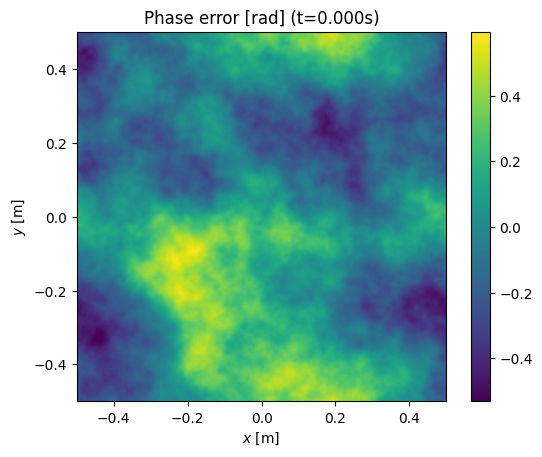

In [ ]:
# Animate a phase screen evolving over time
PLAYBACK_SPEED = 0.2
D = 1.0
dt = 0.01

phi, t = phase_screen_over_time(N=200,
                                D=D,
                                r0=1.0,
                                v=np.array([1.0, 0.0]),
                                M=0.1,
                                t_max=2.0,
                                dt=dt)

fig = plt.figure()
plot = plt.imshow(phi[0], origin="lower", extent=[-D/2, D/2, -D/2, D/2])
plt.xlabel("$x$ [m]")
plt.ylabel("$y$ [m]")
plt.title("Phase error [rad]")
colorbar = plt.colorbar()


def animate(i):
    plot.set_array(phi[i])
    plt.title(f"Phase error [rad] (t={i * dt:.3f}s)")
    colorbar.update_normal(plot)


ani = anim.FuncAnimation(fig, animate, frames=len(t))
ani.save("plots/phase_screen_evolution.mp4",
         writer=anim.FFMpegWriter(fps=PLAYBACK_SPEED/dt))

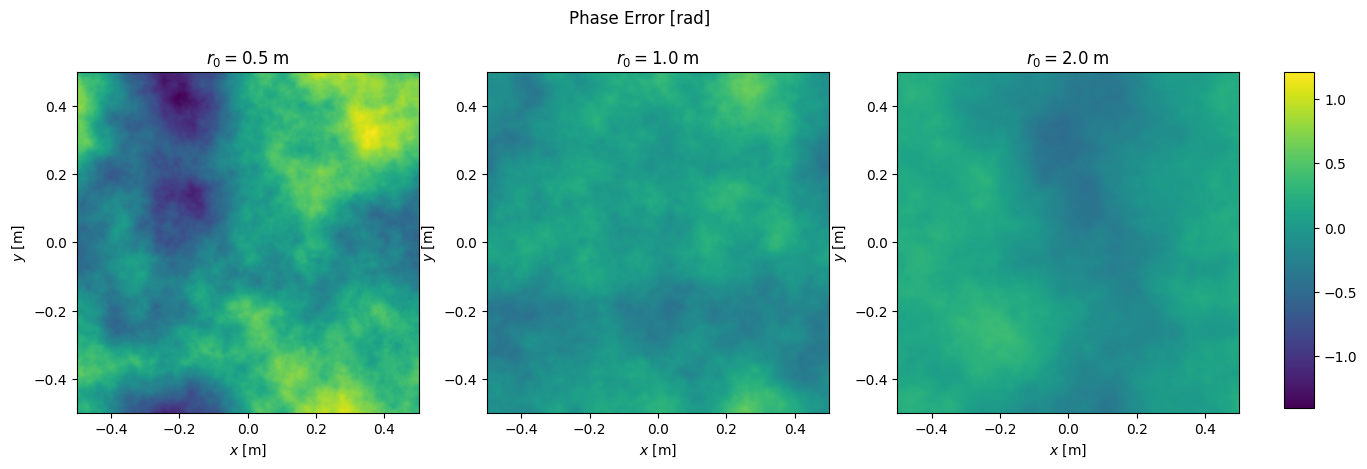

In [56]:
# Plot three phase screens for different values of r0
N = 400
D = 1.0

r0_values = [0.5, 1.0, 2.0]
phase_screens = [phase_screen(N, D, r0) for r0 in r0_values]

fig, axs = plt.subplots(1, len(r0_values))
fig.set_figwidth(15)

vmin = min(np.amin(phi) for phi in phase_screens)
vmax = max(np.amax(phi) for phi in phase_screens)

images = []
for i, (r0, phi) in enumerate(zip(r0_values, phase_screens)):
    images.append(axs[i].imshow(phi, extent=[-D/2, D/2, -D/2, D/2], vmax=vmax, vmin=vmin))
    axs[i].set_xlabel("$x$ [m]")
    axs[i].set_ylabel("$y$ [m]")
    axs[i].set_title(f"$r_0 = {r0}$ m")

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(images[0], cbar_ax)

plt.suptitle("Phase Error [rad]")
plt.show()

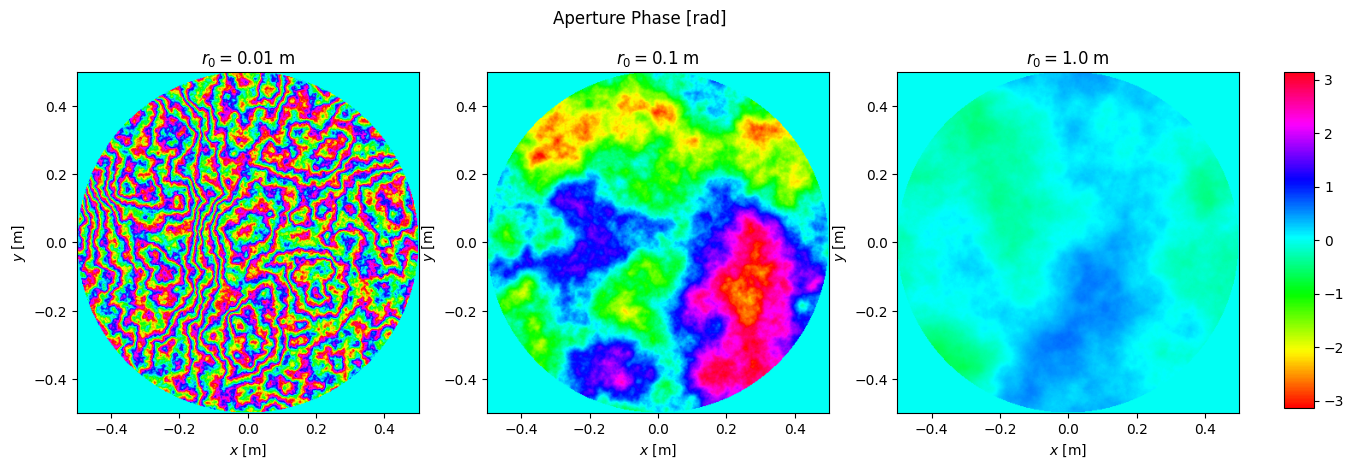

In [91]:
# Plot three apertures
N = 400
D = 1.0

r0_values = [0.01, 0.1, 1.0]
apertures = [
    pupil_function(N, D) * np.angle(pupil_function(N, D) * np.exp(1j * phase_screen(N, D, r0))) 
    for r0 in r0_values
]

fig, axs = plt.subplots(1, len(r0_values))
fig.set_figwidth(15)

images = []
for i, (r0, U) in enumerate(zip(r0_values, apertures)):
    images.append(axs[i].imshow(U, extent=[-D/2, D/2, -D/2, D/2], vmax=np.pi, vmin=-np.pi, cmap="hsv"))
    axs[i].set_xlabel("$x$ [m]")
    axs[i].set_ylabel("$y$ [m]")
    axs[i].set_title(f"$r_0 = {r0}$ m")

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(images[0], cbar_ax)

plt.suptitle("Aperture Phase [rad]")
plt.show()

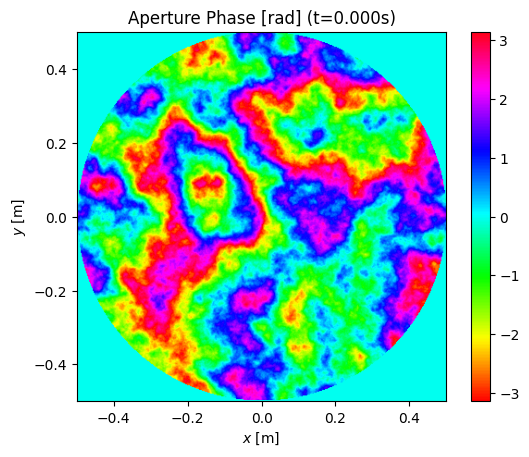

In [8]:
# Animate aperture evolving over time
PLAYBACK_SPEED = 0.2
D = 1.0
N = 400
dt = 0.01

U, t = aperture_over_time(N=N,
                          D=D,
                          r0=0.05,
                          v=np.array([1.0, 0.0]),
                          M=0.1,
                          t_max=2.0,
                          dt=dt)

p = pupil_function(N, D)
fig = plt.figure()
plot = plt.imshow(np.angle(U[0]) * p, cmap="hsv",
                  origin="lower", extent=[-D/2, D/2, -D/2, D/2])
plt.xlabel("$x$ [m]")
plt.ylabel("$y$ [m]")
colorbar = plt.colorbar()


def animate(i):
    plot.set_array(np.angle(U[i]) * p)
    plt.title(f"Aperture Phase [rad] (t={i * dt:.3f}s)")
    colorbar.update_normal(plot)


ani = anim.FuncAnimation(fig, animate, frames=len(t))
ani.save("plots/aperture_evolution.mp4",
         writer=anim.FFMpegWriter(fps=PLAYBACK_SPEED/dt))

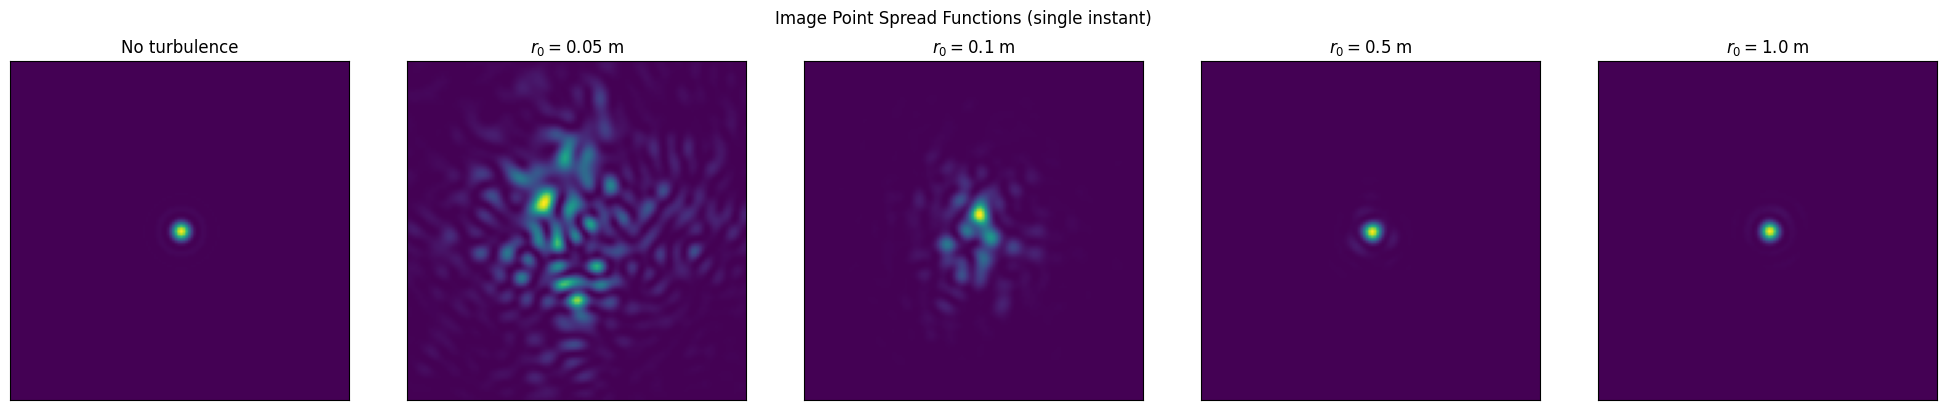

In [177]:
# Plot ideal and turbulent PSFs
N = 400
D = 1.0
ds = 5e-4
f = 10.0
wl = 500e-9
N_sensor = 1024

f_max = ds / (f * wl) 
amplitude_psf_ideal = aperture_to_image(pupil_function(N, D), D, N, f_max, N_sensor)
intensity_psf_ideal = crop_center(np.square(np.abs(amplitude_psf_ideal)), N_sensor // 8)

r0_values = [0.05, 0.1, 0.5, 1.0]
intensity_psfs = [
    point_spread_function_over_time(f, ds, wl, N_sensor, N, D, r0, np.array([2.0, 0.0]), 0.2, t_max=0.0, dt=0.1)[0]
    for r0 in r0_values
]

size = 1000 * ds * intensity_psfs[0].shape[1] / N_sensor

# Plot for single instant
fig, axs = plt.subplots(1, 1 + len(r0_values))
fig.set_figwidth(20)
fig.tight_layout()

images = []
images.append(axs[0].imshow(intensity_psf_ideal, extent=[-size/2, size/2, -size/2, size/2]))
axs[0].set_title("No turbulence")
axs[0].set_xticks([])
axs[0].set_yticks([])

for i, (r0, psfs) in enumerate(zip(r0_values, intensity_psfs)):
    images.append(axs[i+1].imshow(psfs[0], extent=[-size/2, size/2, -size/2, size/2]))
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])
    axs[i+1].set_title(f"$r_0 = {r0}$ m")

plt.suptitle("Image Point Spread Functions (single instant)")
plt.show()

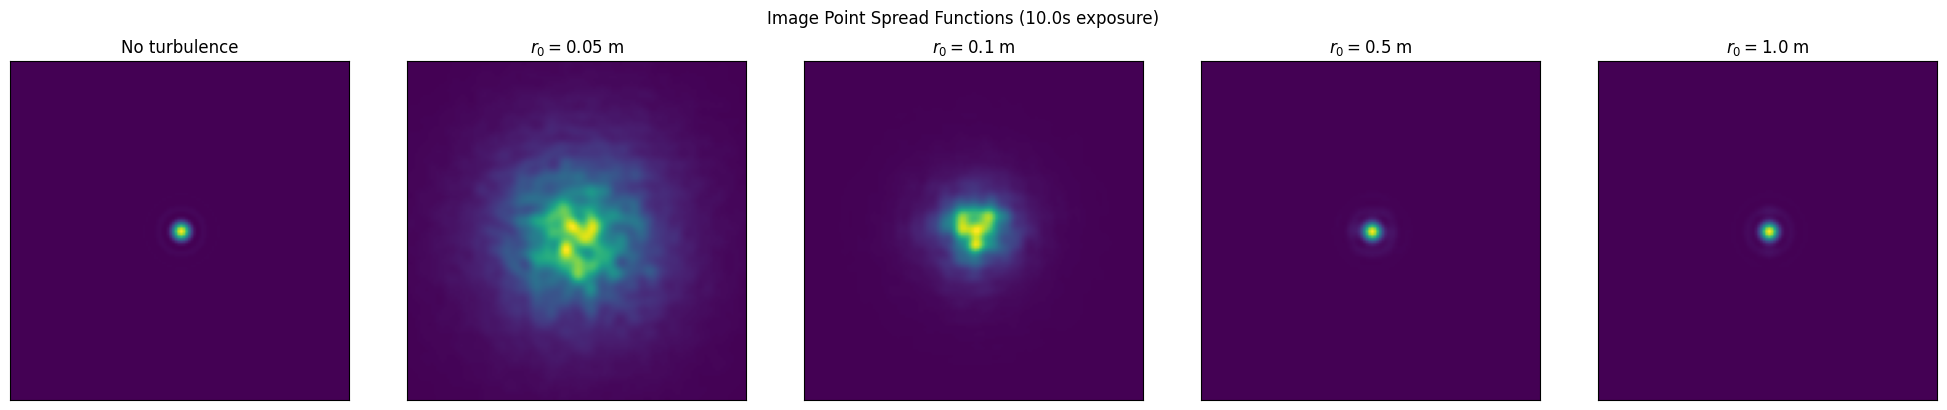

In [178]:
# Plot for long exposure
r0_values = [0.05, 0.1, 0.5, 1.0]
intensity_psfs_average = [
    long_exposure_psf(f, ds, wl, N_sensor, N, D, r0, np.array([2.0, 0.0]), 0.2, 10.0, 100)
    for r0 in r0_values
]
fig, axs = plt.subplots(1, 1 + len(r0_values))
fig.set_figwidth(20)
fig.tight_layout()

images = []
images.append(axs[0].imshow(intensity_psf_ideal, extent=[-size/2, size/2, -size/2, size/2]))
axs[0].set_title("No turbulence")
axs[0].set_xticks([])
axs[0].set_yticks([])

for i, (r0, psf) in enumerate(zip(r0_values, intensity_psfs_average)):
    images.append(axs[i+1].imshow(psf, extent=[-size/2, size/2, -size/2, size/2]))
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])
    axs[i+1].set_title(f"$r_0 = {r0}$ m")

plt.suptitle("Image Point Spread Functions (10.0s exposure)")
plt.show()

In [396]:
# Estimate and plot spot width as a function of r0

def estimate_width(psf: np.ndarray) -> float:
    """
    Return an estimate of the width of the peak in the given point spread function.
    The estimate is the full-width at half-maximum (FWHM) of the peak.

    Returns
        fwhm: Estimate of the spot width for the given psf [pixels]
    """
    # Compute distances from each point to the peak
    peak_x, peak_y = np.unravel_index(np.argmax(psf), psf.shape)
    x, y = np.meshgrid(np.arange(0, psf.shape[0], 1),
                       np.arange(0, psf.shape[0], 1))


    peak_dist = np.ravel(np.hypot(x-peak_x, y-peak_y))
    intensity = np.ravel(psf)

    # Group distances from the peak into bins, and calculate the mean intensity in each (removing nans)
    N_BINS = 100
    bins = np.linspace(0, np.max(peak_dist), N_BINS)
    peak_dist_bins = np.digitize(peak_dist, bins, right=False)

    bin_intensities_with_nan = np.array([np.mean(intensity[peak_dist_bins == b]) for b in range(N_BINS)])
    bin_intensities = bin_intensities_with_nan[~np.isnan(bin_intensities_with_nan)]
    bins_no_nan = bins[~np.isnan(bin_intensities_with_nan)]

    # Interpolate to find the distance value corresponding to 50% intensity
    fwhm = 2.0 * np.interp(-np.nanmax(bin_intensities) / 2, -bin_intensities, bins_no_nan)
    return fwhm


print([estimate_width(psf) for psf in intensity_psfs_average])

[np.float64(45.18277452762878), np.float64(18.34138037431894), np.float64(6.489015251199638), np.float64(6.385511119465447)]


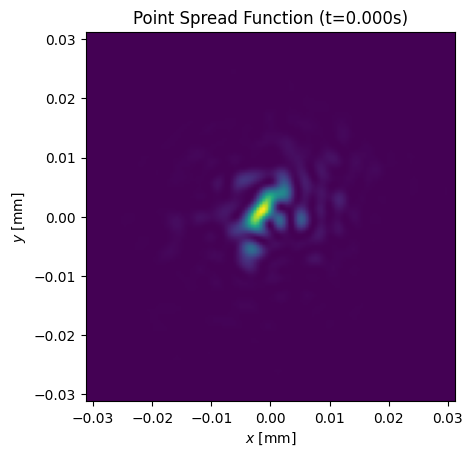

In [ ]:
# Animate point spread function over time
f = 10  # [m]
ds = 0.5e-3  # [m]
wl = 500e-9  # [m]
N_sensor = 1024

PLAYBACK_SPEED = 0.2
dt = 0.01

intensity_PSFs, t = point_spread_function_over_time(f=f,
                                                    ds=ds,
                                                    wl=wl,
                                                    N_sensor=N_sensor,
                                                    N=200,
                                                    D=1.0,
                                                    r0=0.1,
                                                    v=np.array([2.0, 0.0]),
                                                    M=0.2,
                                                    t_max=2.0,
                                                    dt=dt)

# # Animate time dependent PSFs
size = 1000 * ds * intensity_PSFs.shape[1] / N_sensor
fig = plt.figure()
plot = plt.imshow(intensity_PSFs[0], origin="lower", extent=[-size/2, size/2, -size/2, size/2])
plt.xlabel("$x$ [mm]")
plt.ylabel("$y$ [mm]")


def animate(i):
    plot.set_array(intensity_PSFs[i])
    plt.title(f"Point Spread Function (t={i * dt:.3f}s)")

ani = anim.FuncAnimation(fig, animate, frames=len(t))
ani.save("plots/psf_evolution.mp4",
         writer=anim.FFMpegWriter(fps=PLAYBACK_SPEED/dt))

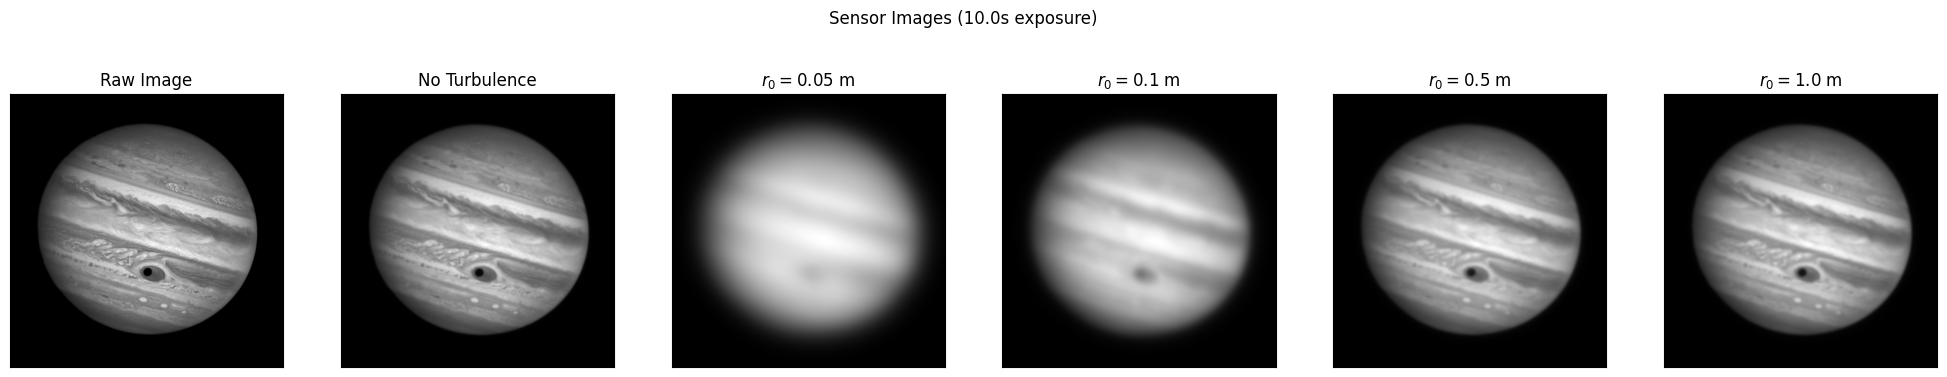

In [169]:
# Animate image function over time
f = 10  # [m]
ds = 0.5e-3  # [m]
wl = 500e-9  # [m]
N_sensor = 512
    
# Load ideal image
image_raw = load_image("images/jupiter.jpg", size=N_sensor)

fig, axs = plt.subplots(1, 2 + len(r0_values))
fig.set_figwidth(20)
fig.tight_layout()

axs[0].imshow(image_raw, cmap="gray")
axs[0].set_title("Raw Image")
axs[0].set_xticks([])
axs[0].set_yticks([])

image_ideal = convolve2d(image_raw, intensity_psf_ideal, mode="same")
axs[1].imshow(image_ideal, cmap="gray")
axs[1].set_title("No Turbulence")
axs[1].set_xticks([])
axs[1].set_yticks([])

for i, (r0, psf) in enumerate(zip(r0_values, intensity_psfs_average)):
    axs[i+2].imshow(convolve2d(image_raw, psf, mode="same"), cmap="gray")
    axs[i+2].set_xticks([])
    axs[i+2].set_yticks([])
    axs[i+2].set_title(f"$r_0 = {r0}$ m")

plt.suptitle("Sensor Images (10.0s exposure)")
plt.show()

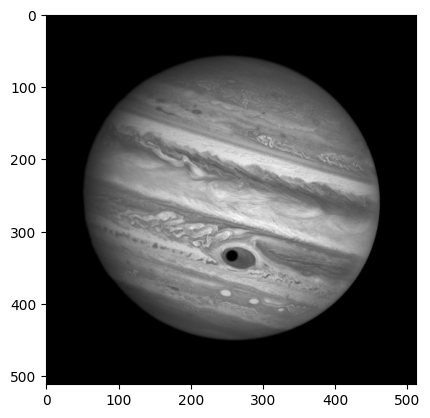

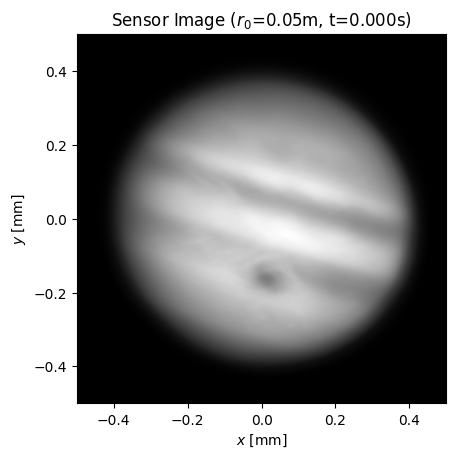

In [170]:
# Animate image function over time
f = 10  # [m]
ds = 0.5e-3  # [m]
wl = 500e-9  # [m]
N_sensor = 512
    
PLAYBACK_SPEED = 0.2
dt = 0.01

images, t = image_over_time(image_file="images/jupiter.jpg",
                            f=f,
                            ds=ds,
                            wl=wl,
                            N_sensor=N_sensor,
                            N=200,
                            D=1.0,
                            r0=0.05,
                            v=np.array([2.0, 0.0]),
                            M=0.2,
                            t_max=2.0,
                            dt=dt)


# Animate time dependent PSFs
fig = plt.figure()
plot = plt.imshow(images[0], cmap="gray",
                  extent=[-ds*1000, ds*1000, -ds*1000, ds*1000])
plt.xlabel("$x$ [mm]")
plt.ylabel("$y$ [mm]")


def animate(i):
    plot.set_array(images[i])
    plt.title(f"Sensor Image ($r_0$=0.05m, t={i * dt:.3f}s)")


ani = anim.FuncAnimation(fig, animate, frames=len(t))
ani.save("plots/image_evolution.mp4",
         writer=anim.FFMpegWriter(fps=PLAYBACK_SPEED/dt))

# TODOs:
* Plot spot size against r0
* Plot variance in peak location against r0
* (Compare the variance from this method to the ideal, 1.0299 (D/r0)^(-5/3))